In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The last time value is :  1488.0


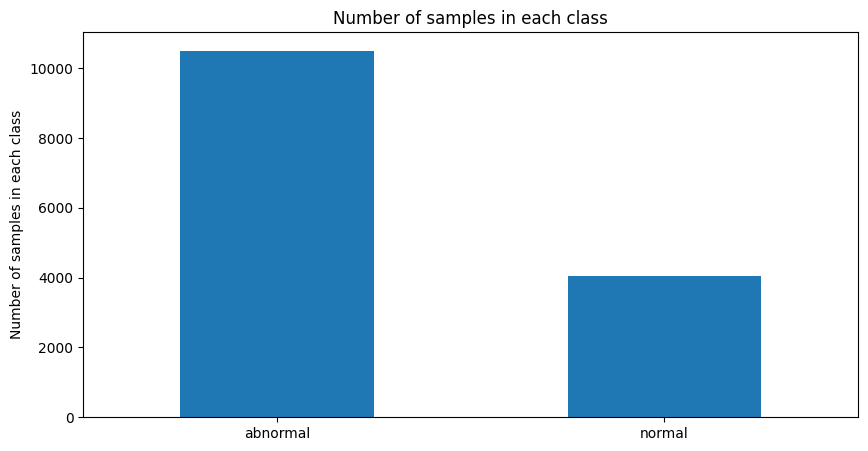

In [4]:
df_ptbd_normal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_abnormal.csv", header = None)

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal",
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.ylabel("Number of samples in each class")
plt.title("Number of samples in each class")
plt.show()

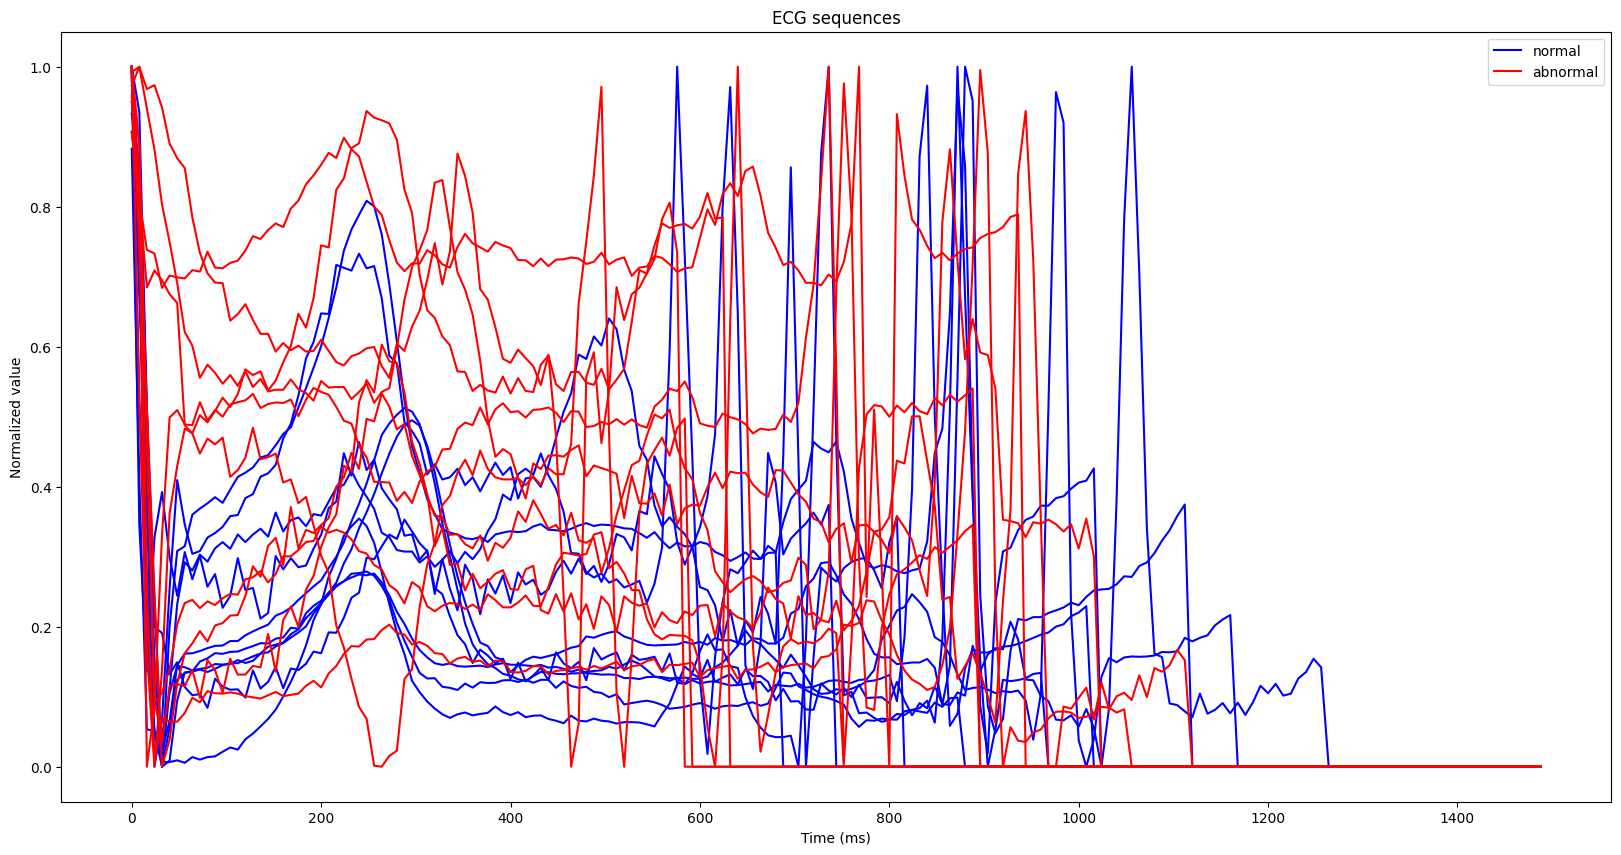

In [5]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df_ptbd.iloc[:, :187].values
y = df_ptbd.iloc[:, 187].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters for binary classification
params = {
    'max_depth': 7,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'error',  # Use binary classification error as evaluation metric
    'subsample': 0.5,
    'colsample_bytree': 0.4, #97.3 at 0.5 ||
    #'tree_method': 'gpu_hist'  # If you have a compatible GPU
}

# Train the XGBoost model with early stopping
num_rounds = 150 #97.35 at 150
early_stopping_rounds = 50
watchlist = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

# Make predictions on the testing set
y_pred = model.predict(dtest)

# Convert the predicted probabilities to binary labels (0 or 1) using a threshold (0.5)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Calculate classification report
class_names = ['Normal', 'Abnormal']
report = classification_report(y_test, y_pred_binary, target_names=class_names)
print("Classification Report:")
print(report)

[0]	train-error:0.12877	test-error:0.14531
[1]	train-error:0.09802	test-error:0.10787
[2]	train-error:0.09114	test-error:0.10306
[3]	train-error:0.08281	test-error:0.09997
[4]	train-error:0.08083	test-error:0.09756
[5]	train-error:0.07688	test-error:0.09241
[6]	train-error:0.06838	test-error:0.08794
[7]	train-error:0.06795	test-error:0.08554
[8]	train-error:0.06408	test-error:0.08245
[9]	train-error:0.05927	test-error:0.07901
[10]	train-error:0.05833	test-error:0.07867
[11]	train-error:0.05481	test-error:0.07454
[12]	train-error:0.05386	test-error:0.07592
[13]	train-error:0.05043	test-error:0.07180
[14]	train-error:0.04922	test-error:0.07077
[15]	train-error:0.04888	test-error:0.07351
[16]	train-error:0.04716	test-error:0.07008
[17]	train-error:0.04321	test-error:0.06630
[18]	train-error:0.04252	test-error:0.06596
[19]	train-error:0.04166	test-error:0.06561
[20]	train-error:0.04037	test-error:0.06527
[21]	train-error:0.03831	test-error:0.06252
[22]	train-error:0.03763	test-error:0.0608